In [1]:
from datasets.classification_dataset import DermaClassificationDataset
from pathlib import Path
import pandas as pd

def get_dataset_image_root() -> Path:
    """Returns the path to the root of the classification dataset"""
    return Path("/Volumes/PortableSSD/dataset-clau/clon_dataset/clon500")

def get_classification_csv_path() -> Path:
    """Returns the path to the csv file containing the information about the images
    and their classifications"""
    return Path("./datasets/csv_files/clean_classification_dataset.csv")


In [2]:
# from sklearn.model_selection import train_test_split
from utils.splitters import train_test_split_for_unbalanced_dataframes, reduce_the_other_category


all_images_df = pd.read_csv(get_classification_csv_path())
all_images_df = reduce_the_other_category(all_images_df, to_percentage=0.18)
# train_files, val_files = train_test_split(all_images_df, test_size=0.2, random_state=42)
train_files, test_files = train_test_split_for_unbalanced_dataframes(all_images_df, test_percentage=0.2, column_name="metaclass", seed=35)

train_files, val_files = train_test_split_for_unbalanced_dataframes(train_files, test_percentage=0.16, column_name="metaclass", seed=35)

print(f"Size of training images: {len(train_files)}")
print(f"Size of validation images: {len(val_files)}")
print(f"Size of test images: {len(test_files)}")

Size of training images: 13690
Size of validation images: 2609
Size of test images: 4078


In [3]:
from preprocessing.dataset_transforms import (
    get_classification_train_transforms_v2,
    get_classification_evaluation_transform_v2,
)

all_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=all_images_df,
    transform=None,
)

train_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=train_files,
    transform=None,
)

val_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=val_files,
    transform=None,
)

test_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=test_files,
    transform=None
)

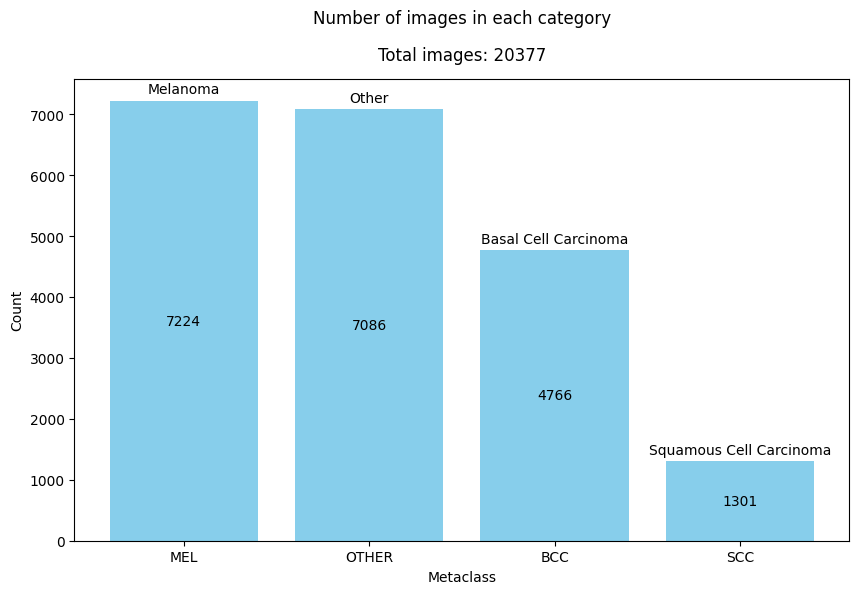

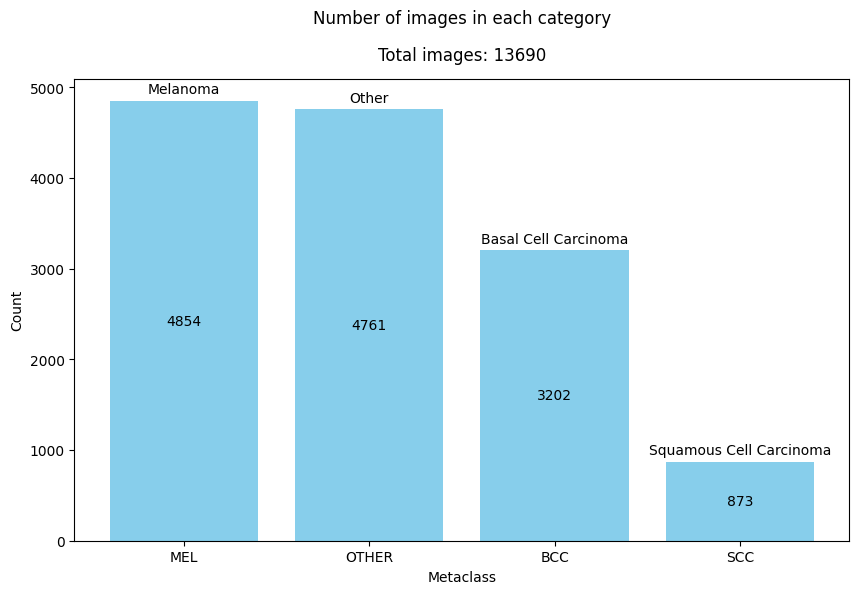

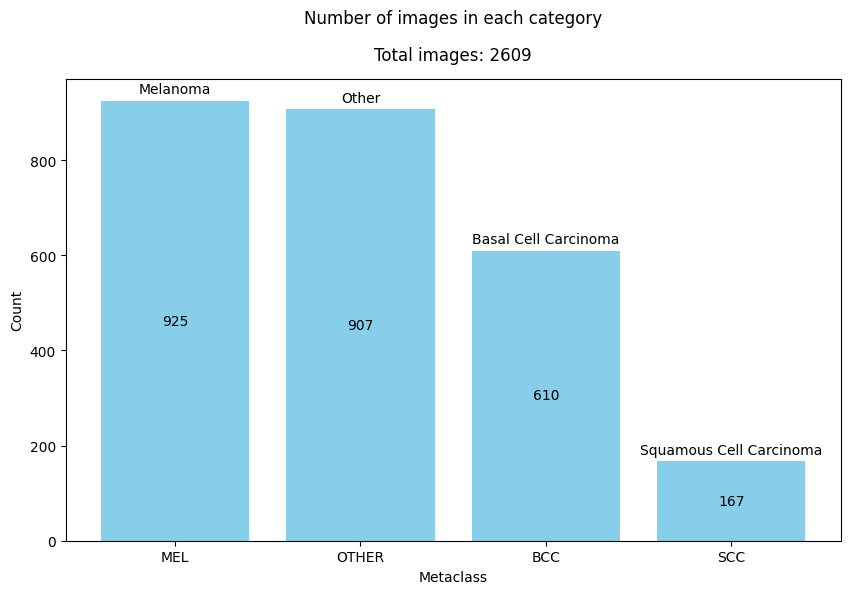

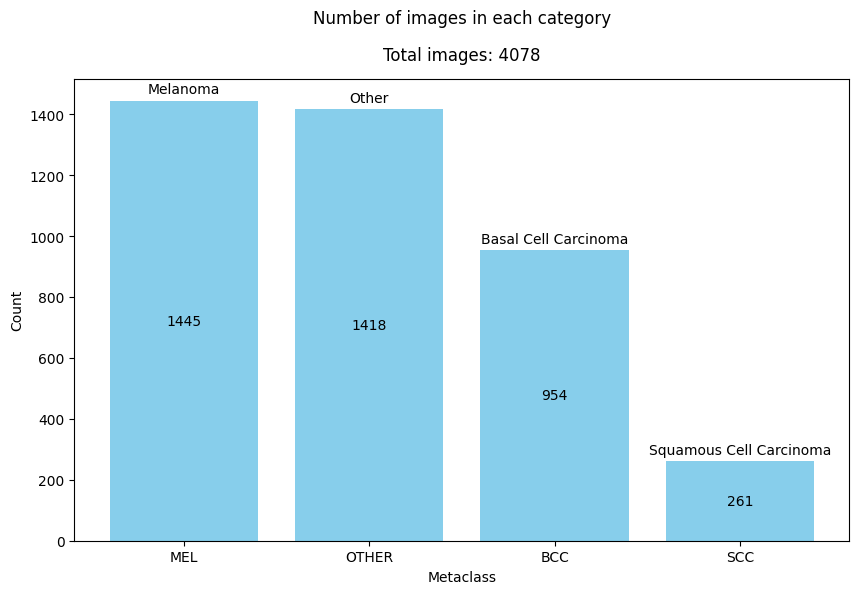

In [4]:
all_dataset.plot_class_distribution()
train_dataset.plot_class_distribution()
val_dataset.plot_class_distribution()
test_dataset.plot_class_distribution()

In [5]:
all_images_df
res = all_images_df["classification"].value_counts()
res = res.reset_index()
res.columns = ["classification", "count"]
total = res["count"].sum()
print(res)

                classification  count
0                     melanoma   7224
1                        nevus   5856
2         basal_cell_carcinoma   4766
3      squamous_cell_carcinoma   1301
4         seborrheic_keratosis    342
5            actinic_keratosis    242
6   pigmented_benign_keratosis    241
7                solar_lentigo    100
8               dermatofibroma     71
9              vascular_lesion     60
10         lichenoid_keratosis     55
11                 acrochordon     54
12                     verruca     21
13                     angioma     12
14         melanoma_metastasis      7
15             lentigo_simplex      7
16                        scar      5
17                       other      5
18                neurofibroma      4
19               angiokeratoma      2
20       sebaceous_hyperplasia      1
21        clear_cell_acanthoma      1


In [6]:
train_dl = train_dataset.get_balanced_dataloader(batch_size=32, num_workers=8)

val_dl = val_dataset.get_basic_dataloader(batch_size=32, num_workers=8)

100%|██████████| 13690/13690 [00:00<00:00, 750431.57it/s]


In [7]:
from tqdm import tqdm

def get_image_counts_by_category(dataloader):
    """
    Returns a dictionary with the count of images in each category from the given DataLoader.

    Args:
        dataloader (DataLoader): The DataLoader to analyze.

    Returns:
        dict: A dictionary where each key is a category (as an integer) and the value is the total count of images in that category.
    """
    category_counts = {}

    # Iterate over the DataLoader
    for index, batch in tqdm(enumerate(dataloader), total=len(dataloader), colour="blue", leave=True):
        _, labels = batch

        # Iterate over the labels in the batch
        for label in labels:
            label = label.item()  # Convert tensor to integer
            if label in category_counts:
                category_counts[label] += 1
            else:
                category_counts[label] = 1

    return category_counts

In [8]:
first = get_image_counts_by_category(train_dl)
second = get_image_counts_by_category(val_dl)

print(f"The first dataloader have the following distribution:\n\t{first.items()}")
print(f"The second dataloader have the following distribution:\n\t{second.items()}")

100%|██████████| 82/82 [01:11<00:00,  1.14it/s]

The first dataloader have the following distribution:
	dict_items([(2, 3420), (0, 3428), (3, 3413), (1, 3429)])
The second dataloader have the following distribution:
	dict_items([(1, 925), (2, 907), (0, 610), (3, 167)])


## Training

In [9]:
from models.resnet_transfer_learning import get_resnet50
import torchsummary
import torch

In [10]:
from models.efficientnet_transfer_learning import get_device, get_efficient_net_b2, get_efficient_net_b2_transformations

device = get_device()

In [11]:
def train_batch(x, y, model, optimizer, criteria):
    """Train a batch of data and return the loss value and accuracy"""
    model.train()
    optimizer.zero_grad()
    prediction = model(x)
    batch_loss = criteria(prediction, y)
    batch_loss.backward()
    optimizer.step()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    _, argmaxes = prediction.max(-1)
    correct_predictions = (y == argmaxes).sum().item()
    total_examples = y.size(0)
    return correct_predictions, total_examples

@torch.no_grad()
def validation_loss(x, y, model, criteria):
    """Validate a batch of data and return the loss value and the number of correct predictions"""
    model.eval()
    prediction = model(x)
    batch_loss = criteria(prediction, y)
    return batch_loss.item()

In [12]:
import shutil

def train_epochs(
    model,
    optimizer,
    criteria,
    train_dl,
    val_dl,
    device,
    epochs=10,
    save_every_epoch:int = 3,
    save_path: Path = Path("./saved_models"),
):
    if save_path.exists():
        shutil.rmtree(save_path)
    save_path.mkdir(parents=True, exist_ok=True)
    """Train the model for a number of epochs"""
    
    if device is None:
        device = get_device()
    model.to(device)

    # Initialize metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        for _, batch in tqdm(
            enumerate(train_dl),
            total=len(train_dl),
            desc=f"Training epoch {epoch+1}/{epochs}",
            colour="red",
        ):
            x, y = batch
            x, y = x.to(device=device), y.to(device=device)
            total_train_loss += train_batch(x, y, model, optimizer, criteria)
            correct, batch_size = accuracy(x, y, model)
            total_train_correct += correct
            total_train_samples += batch_size

        train_loss = total_train_loss / len(train_dl)
        train_accuracy = total_train_correct / total_train_samples
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Training Loss: {train_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.4f}")

        # Initialize validation metrics
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0
        for _, batch in tqdm(
            enumerate(val_dl),
            total=len(val_dl),
            desc=f"Validation on {epoch+1}/{epochs}",
            colour="green",
        ):
            x, y = batch
            x, y = x.to(device=device), y.to(device=device)
            total_val_loss += validation_loss(x, y, model, criteria)
            correct, batch_size = accuracy(x, y, model)
            total_val_correct += correct
            total_val_samples += batch_size

        val_loss = total_val_loss / len(val_dl)
        val_accuracy = total_val_correct / total_val_samples
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        if (epoch + 1) in (1, epochs) or (epoch + 1) % save_every_epoch == 0:
            model.to("cpu")
            torch.save(model.state_dict(), save_path/f"model_epoch_{epoch + 1}.pth")
            model.to(device)
    return train_losses, train_accuracies, val_losses, val_accuracies

### Efficient Net


In [13]:

model, loss, optimizer = get_efficient_net_b2(num_classes=4, dropout_rate=0.5, learning_rate=1e-4)

train_transformation, validation_transform = get_efficient_net_b2_transformations()


The name of the device is mps


In [14]:
train_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=train_files,
    transform=train_transformation,
)

val_dataset = DermaClassificationDataset(
    root_img_folder=get_dataset_image_root(),
    image_dataframe=val_files,
    transform=validation_transform,
)

In [15]:
train_dl = train_dataset.get_balanced_dataloader(batch_size=32, num_workers=12, pin_memory=True, drop_last=False,)
val_dl = val_dataset.get_basic_dataloader(batch_size=32, num_workers=12, pin_memory=True, drop_last=False,)

100%|██████████| 13690/13690 [00:00<00:00, 1020945.59it/s]


In [16]:
train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model=model,
    device=device,
    optimizer=optimizer,
    criteria=loss,
    train_dl=train_dl,
    val_dl=val_dl,
    epochs=16,
    save_every_epoch=3,
    save_path=Path("./saved_models/efficient_net"),
)

Training epoch 1/16:   0%|          | 0/428 [05:31<?, ?it/s]
